In [1]:
import pandas as pd

data=pd.read_csv("18100205.csv")

data.head() #to display the first 5 lines of loaded data

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1
1,1981-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1
2,1981-01,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,40.6,NaN,NaN,NaN,1
3,1981-01,Atlantic Region,2016A00011,Total (house and land),"Index, 201612=100",347,units,0,v111955445,2.1,NaN,..,NaN,NaN,1
4,1981-01,Atlantic Region,2016A00011,House only,"Index, 201612=100",347,units,0,v111955446,2.2,NaN,..,NaN,NaN,1


In [2]:
data.dtypes

REF_DATE                      object
GEO                           object
DGUID                         object
New housing price indexes     object
UOM                           object
UOM_ID                         int64
SCALAR_FACTOR                 object
SCALAR_ID                      int64
VECTOR                        object
COORDINATE                   float64
VALUE                        float64
STATUS                        object
SYMBOL                       float64
TERMINATED                   float64
DECIMALS                       int64
dtype: object

In [2]:
data = data[['REF_DATE', 'GEO', 'New housing price indexes', 'VALUE']].rename(columns = {'New housing price indexes' : 'HPI_TYPE', 'VALUE' : 'HPI'})

In [4]:
data.head()

,REF_DATE,GEO,HPI_TYPE,HPI
0,1981-01,Canada,Total (house and land),38.2
1,1981-01,Canada,House only,36.1
2,1981-01,Canada,Land only,40.6
3,1981-01,Atlantic Region,Total (house and land),NaN
4,1981-01,Atlantic Region,House only,NaN


In [3]:
filtered_data = data.loc[(data.GEO == 'Canada') & (data.HPI_TYPE == 'Total (house and land)')]

In [6]:
filtered_data.head()

,REF_DATE,GEO,HPI_TYPE,HPI
0,1981-01,Canada,Total (house and land),38.2
120,1981-02,Canada,Total (house and land),38.7
240,1981-03,Canada,Total (house and land),39.3
360,1981-04,Canada,Total (house and land),39.9
480,1981-05,Canada,Total (house and land),40.6


In [4]:
filtered_data2 = filtered_data.loc[:,('REF_DATE', 'HPI')]

filtered_data2.REF_DATE = pd.to_datetime(filtered_data2.REF_DATE)
filtered_data2.set_index('REF_DATE', inplace=True)

#filtered_data.index = pd.to_datetime(filtered_data.index, format='%Y-%m', errors='coerce').dropna()

filtered_data2.dtypes

filtered_data2.head()

,HPI
REF_DATE,
1981-01-01,38.2
1981-02-01,38.7
1981-03-01,39.3
1981-04-01,39.9
1981-05-01,40.6


In [5]:
import datetime
import matplotlib.dates as mdates

# change the dates into ints for training 
filtered_data3 = filtered_data2.copy()
filtered_data3 = filtered_data3.reset_index()

# Store the original dates for plotting the predicitons
org_dates = filtered_data3['REF_DATE']

# convert to ints
filtered_data3['REF_DATE_INT'] = (filtered_data3['REF_DATE'].map(mdates.date2num))#%700000)/2318

filtered_data3.insert(0, 'New_ID', range(100, 100 + len(filtered_data3)))

filtered_data3.head()
#filtered_data3['REF_DATE_INT'].astype(int) *2381+700000

,New_ID,REF_DATE,HPI,REF_DATE_INT
0,100,1981-01-01,38.2,723181.0
1,101,1981-02-01,38.7,723212.0
2,102,1981-03-01,39.3,723240.0
3,103,1981-04-01,39.9,723271.0
4,104,1981-05-01,40.6,723301.0


In [6]:
train_data = filtered_data3.iloc[:-30]
train_data = train_data.loc[:,'HPI'].to_numpy()
print(train_data.shape)


(434,)


In [7]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [8]:
#print(train_data)
print(len(train_data))

434


In [9]:
#function to create ann input features
def ann_input(input_data, time_window):
    feature_hpi, predict_hpi = [], []
    for i in range(len(input_data)-time_window):
        a = input_data[i:(i + time_window), 0]
        feature_hpi.append(a)
        predict_hpi.append(input_data[i + time_window, 0])
    return np.array(feature_hpi), np.array(predict_hpi)

In [10]:
import numpy as np 
# call function to create the data to train our model on:
time_steps = 36
feature_hpi, predict_hpi = ann_input(train_data, time_steps)

# reshape it [samples, time steps, features]
feature_hpi = np.reshape(feature_hpi, (feature_hpi.shape[0], time_steps, 1))

print(feature_hpi.shape)
print("\n")

# features structure visualization: 
print('feature_hpi: ')
print(str(scaler.inverse_transform(feature_hpi[0])))
print("\n")
print('predict_hpi: ' + str(scaler.inverse_transform(predict_hpi[0].reshape(-1,1)))+'\n')

(398, 36, 1)


feature_hpi: 
[[38.2]
 [38.7]
 [39.3]
 [39.9]
 [40.6]
 [40.8]
 [40.8]
 [40.6]
 [40.4]
 [40.3]
 [40.2]
 [40.3]
 [40.3]
 [40.3]
 [40.1]
 [39.9]
 [39.6]
 [39.3]
 [39. ]
 [38.8]
 [38.4]
 [38.3]
 [38. ]
 [37.9]
 [37.9]
 [37.9]
 [37.8]
 [37.8]
 [37.7]
 [37.8]
 [37.8]
 [38. ]
 [38. ]
 [37.9]
 [38. ]
 [37.9]]


predict_hpi: [[38.]]



In [11]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Build the model 
hpi_prediction = keras.Sequential()

hpi_prediction.add(LSTM(units = 100, return_sequences = True, input_shape = (feature_hpi.shape[1], 1)))
hpi_prediction.add(Dropout(0.2))

hpi_prediction.add(LSTM(units = 100))
hpi_prediction.add(Dropout(0.2))

# Output layer
hpi_prediction.add(Dense(units = 1))

# Compiling the model
hpi_prediction.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')

# Fitting the model to the Training set
history = hpi_prediction.fit(feature_hpi, predict_hpi, epochs = 200, batch_size = 40, validation_split=.30)


Using TensorFlow backend.


Train on 278 samples, validate on 120 samples
Epoch 1/200
278/278 [==============================] - 1s 5ms/step - loss: 68.7567 - val_loss: 38.5611
Epoch 2/200
278/278 [==============================] - 1s 3ms/step - loss: 52.8603 - val_loss: 5.0304
Epoch 3/200
278/278 [==============================] - 1s 3ms/step - loss: 44.7389 - val_loss: 7.4149
Epoch 4/200
278/278 [==============================] - 1s 3ms/step - loss: 35.7133 - val_loss: 7.6271
Epoch 5/200
278/278 [==============================] - 1s 3ms/step - loss: 24.8881 - val_loss: 9.2268
Epoch 6/200
278/278 [==============================] - 1s 3ms/step - loss: 21.0333 - val_loss: 6.0102
Epoch 7/200
278/278 [==============================] - 1s 3ms/step - loss: 17.5962 - val_loss: 14.5342
Epoch 8/200
278/278 [==============================] - 1s 3ms/step - loss: 23.2769 - val_loss: 4.1718
Epoch 9/200
278/278 [==============================] - 1s 3ms/step - loss: 18.9606 - val_loss: 6.6412
Epoch 10/200
278/278 [============

278/278 [==============================] - 1s 3ms/step - loss: 17.4647 - val_loss: 4.8581
Epoch 81/200
278/278 [==============================] - 1s 3ms/step - loss: 15.9246 - val_loss: 4.7695
Epoch 82/200
278/278 [==============================] - 1s 3ms/step - loss: 18.8233 - val_loss: 2.3294
Epoch 83/200
278/278 [==============================] - 1s 3ms/step - loss: 11.9456 - val_loss: 5.8416
Epoch 84/200
278/278 [==============================] - 1s 3ms/step - loss: 12.7601 - val_loss: 1.4553
Epoch 85/200
278/278 [==============================] - 1s 3ms/step - loss: 11.3923 - val_loss: 2.6592
Epoch 86/200
278/278 [==============================] - 1s 3ms/step - loss: 20.9332 - val_loss: 10.3446
Epoch 87/200
278/278 [==============================] - 1s 3ms/step - loss: 15.5153 - val_loss: 6.8142
Epoch 88/200
278/278 [==============================] - 1s 3ms/step - loss: 15.6671 - val_loss: 10.0676
Epoch 89/200
278/278 [==============================] - 1s 3ms/step - loss: 14.7288 

278/278 [==============================] - 1s 3ms/step - loss: 10.6824 - val_loss: 3.6947
Epoch 160/200
278/278 [==============================] - 1s 3ms/step - loss: 10.7897 - val_loss: 4.0407
Epoch 161/200
278/278 [==============================] - 1s 3ms/step - loss: 9.8764 - val_loss: 2.2911
Epoch 162/200
278/278 [==============================] - 1s 3ms/step - loss: 10.9941 - val_loss: 1.7840
Epoch 163/200
278/278 [==============================] - 1s 3ms/step - loss: 13.3768 - val_loss: 4.9207
Epoch 164/200
278/278 [==============================] - 1s 3ms/step - loss: 9.9241 - val_loss: 2.0599
Epoch 165/200
278/278 [==============================] - 1s 3ms/step - loss: 10.6264 - val_loss: 1.8709
Epoch 166/200
278/278 [==============================] - 1s 3ms/step - loss: 12.1993 - val_loss: 2.5370
Epoch 167/200
278/278 [==============================] - 1s 3ms/step - loss: 13.0557 - val_loss: 0.8404
Epoch 168/200
278/278 [==============================] - 1s 3ms/step - loss: 13.

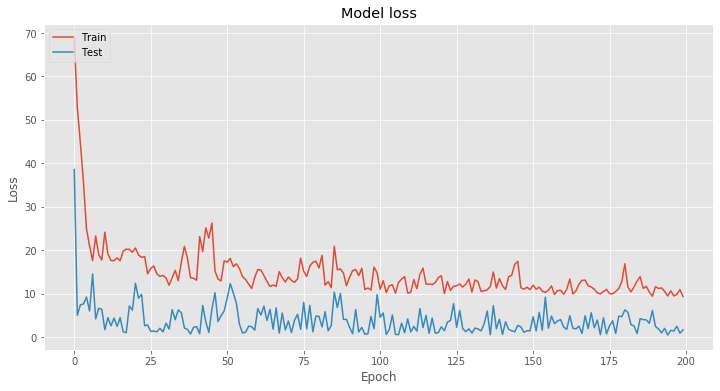

In [12]:
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('ggplot')
register_matplotlib_converters()

# Plot training & validation loss values
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# Use trained model to make prediction
test = filtered_data3.tail(66)
test_hpi = scaler.transform(test['HPI'].values.reshape(-1,1))
#print(test_hpi)
#print(len(test_hpi))

time_steps = 36
X_test, y_test = ann_input(test_hpi, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
#print(y_test)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

# Predict the prices with the model
predicted_y = hpi_prediction.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

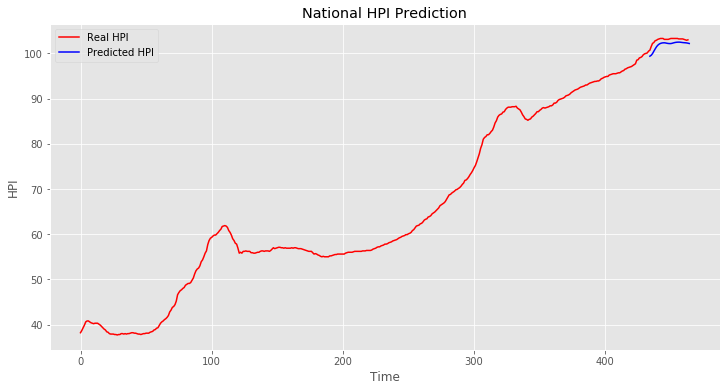

In [14]:
#test = filtered_data3.tail(30)
#test_hpi = scaler.transform(test['HPI'].values.reshape(-1,1))
#test_hpi = test_hpi.reshape(-1,1)
#test_hpi = scaler.transform(test_hpi)
#print(test_hpi)

all_hpi = np.array(filtered_data3['HPI'].values.reshape(-1,1))

# plot the results 
plt.figure(figsize = (12,6))
plt.plot(all_hpi, color = 'red', label = 'Real HPI')
plt.plot(np.linspace(434, 464, len(predicted_y)), predicted_y, color = 'blue', label = 'Predicted HPI')
plt.title('National HPI Prediction')
plt.xlabel('Time')
plt.ylabel('HPI')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(org_y, predicted_y)
print(error)

1.2807580531043954


In [19]:

for layer in hpi_prediction.layers:
    print(layer.name)

lstm_1
dropout_1
lstm_2
dropout_2
dense_1


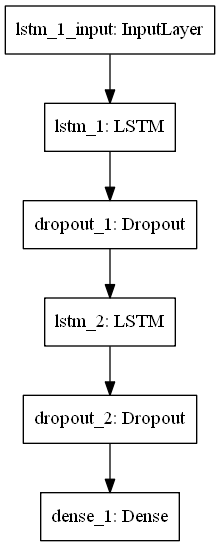

In [21]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from keras.utils import plot_model
plot_model(hpi_prediction, to_file='model.png')